# Research Question 1
What is the impact of the number of different time zones from where developers collaborate on the speed of code review?
</br></br>
We will examine this both in </br>
A. Repository-Level Analysis</br>
B. Pull Request-Level Analysis:

## A. Repository-Level Anaysis
### 1. Process location and obtain average time to merge a pull request 😇
We start by reading the 2 collected data: one for collaborators, users and their location for each repository and the other one for the pull request of each repository. Both of these datasets were gathered and explained in data_collection.ipnyb. 

For each repositoy, we retrieved the location of all collaborators. In a json file, we placed all collaborators that have their location on their GitHub profile, removing all collaborators that have 'Null' values as their locations. The criteria of retrieving their location is the following: we will take the location of the user if they have it on their github, otherwise we take their location from their 'bio', and if they do not have these, we take their location from 'company' field. 

Moreover, we computed the average time-to-merge for all pull requests in the respective repository. This value can be computed in either hours or minutes. For our analysis we will use hours. 

Furthermore, we have reduced the number of repositories from 51 to 46 😅. This is due to the fact that there were 3 repositories with no pull requests, as we have not filtered them out in the initial part of the data collection. We had to remove these 3 repositories because our analysis surrounds the hypothesis of time-to-merge a pull request, therefore we had no pull requests to analyze in these repositories, thus we removed them. Lastly, we have found 2 repositories that have no collaborators that have location on, this is due to the fact that in the initial data collection process, the collaborators had their location on and passed our filtering criteria of having at least 0.1% of users with location on, however our program below does not parse the location if it is written in another language, and in our case, the location of a user was written in Korean, and our program below considers it as Null 💀. 

In [1]:
import json
from datetime import datetime

def time_difference(d1, d2, unit='hours'):
    d1 = datetime.strptime(d1, '%Y-%m-%dT%H:%M:%SZ')
    d2 = datetime.strptime(d2, '%Y-%m-%dT%H:%M:%SZ')
    
    time_diff = d2 - d1
    
    if unit == 'hours':
        return time_diff.total_seconds() / 3600
    elif unit == 'minutes':
        return time_diff.total_seconds() / 60
    else:
        raise ValueError("Invalid unit. Please use 'hours' or 'minutes'.")

f1 = open("data/5_collaborators_and_users_with_timezone.json")
f2 = open("data/4_pull_requests.json")
data_tz = json.load(f1)
data_pr = json.load(f2)

repos = []

for item in data_pr:
    #print(f"repo name of pr is {item['full_name']}")
    pull_requests = []

    for entry in item['pull_requests']:
        if (entry['created_at'] and entry['merged_at']) is not None:
            pull_requests.append(time_difference(entry['created_at'], entry['merged_at'],'hours'))
    if len(pull_requests) == 0:
        average_pull_requests = 0
    elif len(pull_requests) > 0:
        average_pull_requests = sum(pull_requests) / len(pull_requests)
    
    repos.append({
        "repo_name": item['full_name'],
        "pull_requests": pull_requests,
        "pull_request_average": average_pull_requests
    })


final_repos = []
i = 0
for item in data_tz:
    locations = []
    for entry in item['users_location']:
        if 'bot' not in entry['login']:
            if entry['location'] is not None:
                locations.append(entry['location'])
            elif entry['bio'] is not None:
                locations.append(entry['bio'])
            elif entry['company'] is not None:
                locations.append(entry['company'])

    if len(locations) != 0:
        repo_index = next((i for i, r in enumerate(repos) if r["repo_name"] == item['name']), None)
        if repo_index is not None:
            if repos[repo_index]['pull_request_average'] != 0:
                final_repos.append({
                    "repo_name": item['name'],
                    "locations": locations,
                    "time_to_merge": repos[repo_index]['pull_requests'],
                    "time_to_merge_average": repos[repo_index]['pull_request_average']
                })
        i += 1

with open("data_rq1/RQ1_2_Locations_PR.json", "w") as outfile:
    json.dump(final_repos, outfile)
print("result written in data_rq1/RQ1_2_Locations_PR.json")

result written in data_rq1/RQ1_2_Locations_PR.json


### 2. Retrieve UTC timezones for all collaborators that have their location on 🗺️

From the data we processed in the previous step, we further process it so that we place each location in it's respective UTC timezone. We count how many collaborators of a repository belong to a distinct timezone. We also keep the average time-to-merge for each repositoy.

Moreover, we also count how many distinct timezones there are in a single repository and we also retrieve the timezone difference within a repository. In our case, the timezone difference is the absolute sum of the lowest and highest UTC timezone. For example, if repository A has collaborators from the following UTC timezones: UTC-7, UTC-1, UTC+4 and UTC+10, then the timezone difference will be 17 hours (absolute sum of UTC-7 and UTC+10).

In [26]:
import pytz
from datetime import datetime, timezone
from collections import defaultdict
import json

f = open("data_rq1/RQ1_2_Locations_PR.json")
location_data = json.load(f)

# Initialize the output dictionary
output_data = {}

for item in location_data:
    repo_name = item['repo_name']
    if repo_name not in output_data:
        output_data[repo_name] = {
            "average_pr_time": item['time_to_merge_average']
        }

    timezone_counts = defaultdict(int)
    timezone_offsets = []
    for location in item['locations']:
        try:
            tz_obj = pytz.timezone(location)
            utc_offset = tz_obj.utcoffset(datetime.now())
            if utc_offset.total_seconds() == 0:
                tz_offset_str = "UTC+0"
            else:
                tz_offset_str = f"UTC{'+' if utc_offset.total_seconds() > 0 else '-'}{abs(int(utc_offset.total_seconds() / 3600))}"
            timezone_counts[tz_offset_str] += 1
            
            # Extract the numeric offset from the string
            if tz_offset_str.startswith("UTC+"):
                timezone_offsets.append(int(tz_offset_str[4:]))
            elif tz_offset_str.startswith("UTC-"):
                timezone_offsets.append(-int(tz_offset_str[4:]))
            else:
                timezone_offsets.append(0)
        except pytz.exceptions.UnknownTimeZoneError:
            print(f"Unknown timezone: {location}")

    for timezone, count in timezone_counts.items():
        output_data[repo_name][timezone] = count
    output_data[repo_name]['nr_timezones'] = len(timezone_counts)

    # Calculate the timezone difference
    min_offset = min(timezone_offsets)
    max_offset = max(timezone_offsets)
    timezone_difference = abs(max_offset - min_offset)
    output_data[repo_name]['timezone_difference'] = timezone_difference

with open("data_rq1/RQ1_utc_count_avg_prs.json", "w") as outfile:
    json.dump(output_data, outfile)

print("Result written in data_rq1/RQ1_utc_count_avg_prs.json")

Result written in data_rq1/RQ1_utc_count_avg_prs.json


### 3. Sort timezones for each repository 

In the code below, we sort the timezones for each repository, as they were initially unsorted. We perform this step in order to have a better view of the data and to later create a histogram of frequencies and perform statistical analysis.

In [27]:
import json

f = open("data_rq1/RQ1_utc_count_avg_prs.json")
data = json.load(f)

# Function to order the time zones
def order_timezones(data,repo_name):
    ordered_data = {}
    #add name of repository to the item
    ordered_data['repo_name'] = repo_name

    # Create lists for UTC+ and UTC- timezones
    utc_plus_timezones = []
    utc_minus_timezones = []

    # Populate the lists
    for timezone, count in data.items():
        if timezone.startswith("UTC+"):
            utc_plus_timezones.append((timezone, count))
        elif timezone.startswith("UTC-"):
            utc_minus_timezones.append((timezone, count))
        elif timezone == "average_pr_time" or timezone == "nr_timezones" or timezone == "timezone_difference":
            ordered_data[timezone] = data[timezone]

    # Order the lists
    utc_plus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=False)
    utc_minus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=True)

    # Merge the lists
    ordered_timezones = utc_minus_timezones + utc_plus_timezones

    # Create the final ordered data
    for timezone, count in ordered_timezones:
        ordered_data[timezone] = count

    return ordered_data


utc_list = []

for item in data:
    utc_list.append(order_timezones(data[item],item))


with open("data_rq1/RQ1_utc_ordered_avg_prs.json", "w") as outfile:
    json.dump(utc_list, outfile)
    print("Result written in data_rq1/RQ1_utc_ordered_avg_prs.json")

Result written in data_rq1/RQ1_utc_ordered_avg_prs.json


### 4. Create a histogram for the frequency of all timezones across all repositories 🌏.

In this step, we create a histogram with the frequencies of all timezones across all repositories. In total we have 16 distinct timezones. The most prevalent timezones in our dataset are UTC-7 (West Coast of USA 🤠, e.g. Sillicon Valley), UTC-4 (East Coast of USA 🦅 and Ontario & Quebec from Canada and Central South America), UTC+1 (Central European Time, comprising of countries from Western, Central Europe, including the Scandinavian countries 🥶) and UTC+8 (China, Singapore and Western Australia 😎)

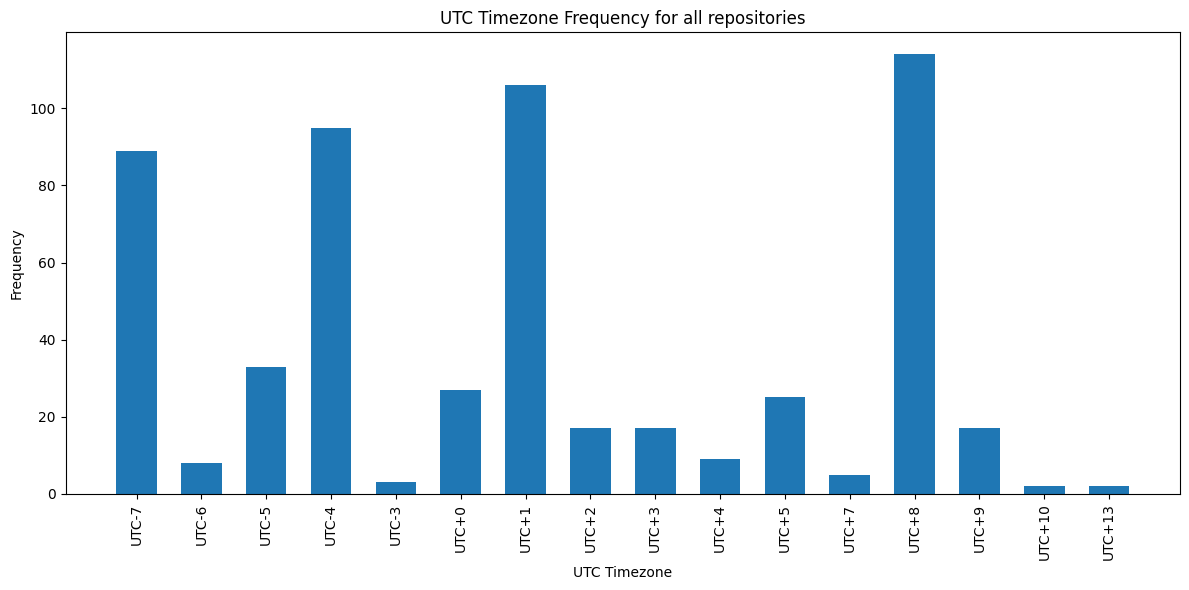

In [28]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open("data_rq1/RQ1_utc_ordered_avg_prs.json", "r") as f:
    data = json.load(f)


# Create a dictionary to store the frequencies
timezone_frequencies = {}

for item in data:
    #print(item['average_pr_time'])
    for timezone, count in item.items():
        if isinstance(count, int) and timezone != "repo_name" and timezone != "average_pr_time" and timezone != "nr_timezones" and timezone != "timezone_difference":
            if timezone not in timezone_frequencies:
                timezone_frequencies[timezone] = 0
            timezone_frequencies[timezone] += count

# Separate the timezones into two lists
utc_plus_timezones = []
utc_minus_timezones = []

for timezone, count in timezone_frequencies.items():
    if timezone.startswith("UTC+"):
        utc_plus_timezones.append((timezone, count))
    elif timezone.startswith("UTC-"):
        utc_minus_timezones.append((timezone, count))

# Order the lists
utc_plus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=False)
utc_minus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=True)

# Merge the lists
frequency_timezones_all_repos = utc_minus_timezones + utc_plus_timezones

# Plot the histogram
plt.figure(figsize=(12, 6))
x_values = [tz[0] for tz in frequency_timezones_all_repos]
y_values = [tz[1] for tz in frequency_timezones_all_repos]
bar_width = 10 / len(frequency_timezones_all_repos)
plt.bar(x_values, y_values, width=bar_width)
plt.xticks(rotation=90)
plt.xlabel("UTC Timezone")
plt.ylabel("Frequency")
plt.title("UTC Timezone Frequency for all repositories")
plt.tight_layout()
plt.show()

### 5. Statistical analysis 🧐

1. Shapiro-Wilk test for Normal Distribution
   - This test checks if the data are normally distributed
   - The p-value of the Shapiro Wilk test is not higher than 0.05 so we accept the null hypothesis (i.e., that the data are not normally distributed). 
2. Spearman test for Variables Relationship
   - The Spearman test assesses how well the relationship between two variables can be described using a monotonic function. We use this to check how strong the relationship between the number of distinct timezones and time-to-merge is.
   - Spearman test for average-time-to-merge and nr distinct timezones is 0.1873624213239356
   This positive value suggests a weak positive monotonic relationship between the two variables. As the number of distinct timezones increases, the average time to merge a pull request tends to increase slightly, but the relationship is relatively weak.
   - We complement this result by also plotting a scatter plot of the relationship between the two variables. From this, we can also confirm that visually no difference can be detected when the number of timezones changes (as the time-to-merge keeps being on the same range).
2. Mann-Whitney U test
   We performed this test due to our data being not normally distributed. We split the repositories into two categories, based on the number of distinct timezones that they have. The threshold we set is calculated based on the median of distinct timezones across all repositories. In this way, we separate the dataset between repositories that have big and small global collaboration.
   - **Mann-Whitney U statistic**: 201.0
   - **p-value**: 0.2556944278708003
   The high p-value suggests that the observed difference between the two groups (repositories with lower number of distinct timezons and higher number of distinct timezones) could be due to random chance or sampling variation, and there is not enough evidence to conclude that the distributions of average time to merge a pull request are different between the two groups.
   In other words, based on the Mann-Whitney U test results, we cannot say with statistical significance that the number of distinct timezones has an impact on the average time to merge a pull request in this dataset.



Average time to merge (hours) does not follow a normal distribution (p value = 0.0008216105634346604 < 0.05)
Spearman test for time-to-merge and nr distinct timezones is 0.2727144523489605 (p-value = 0.07328919871037222)


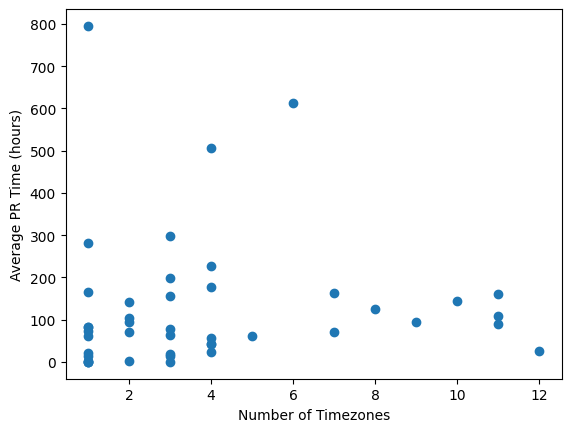

Mann-Whitney U statistic: 172.0
p-value: 0.14209458241876322


In [29]:
import json
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import matplotlib.pyplot as plt

with open('data_rq1/RQ1_utc_ordered_avg_prs.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Shapiro-Wilk test for Normal Distribution
from scipy.stats import shapiro

def test_ShapiroWilk(values, label):
    res = shapiro(values)
    if res.pvalue>0.05: # if true, then normal distibution
        print(f'{label} follows a normal distribution (p value = {res.pvalue} > 0.05)')
    else:
        print(f'{label} does not follow a normal distribution (p value = {res.pvalue} < 0.05)')

timetomerge=df['average_pr_time']
test_ShapiroWilk(y_values, 'Average time to merge (hours)')

# Spearman test
statistic, p_value = stats.spearmanr(df['average_pr_time'], df['nr_timezones'])
print(f"Spearman test for time-to-merge and nr distinct timezones is {statistic} (p-value = {p_value})")

# Scatterplot of average_pr_time vs nr_timezones
plt.scatter(df['nr_timezones'], df['average_pr_time'])
plt.xlabel('Number of Timezones')
plt.ylabel('Average PR Time (hours)')
plt.show()

# Mann-Whitney U-test
median_nr_timezones = df['nr_timezones'].median()
group1 = df[df['nr_timezones'] < median_nr_timezones]['average_pr_time']
group2 = df[df['nr_timezones'] >= median_nr_timezones]['average_pr_time']

stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat}")
print(f"p-value: {p_value}")


### 6. Explore the impact of Simpson's Index of Diversity on Time-to-merge
Simpson's Index of Diversity is a measure which takes into account the number of timezones present, as well as the relative abudance of each timezone. This is a more descriptive measure, than the number of distinct timezones, in the sense that it also takes into account the number of people that belong to a timezone. 

Simpson's Index of Diversity can be calculated as: 
S = 1- sum(n/N)^2. 
where n = the total number of people of a particular timezone,
N = the total number of people (collaborators) of all timezones

The higher the value of the Simpson's Index of Diversity, the higher the diversity. For example, if in a repository, 50% of the contributors belong to one timezone and the other 50% to another, then the SID=0.5. However, if 10% of them belong to one repository and 90% belong to another, then SID=0.18. The second repository has less diversity than the first one, as most of the people belong to the same timezone.


1. We plot a scatter plot to see the relationship between this metric and time to merge. Similar to the distinct number of timezones, no significant difference can be identified visually. 
2. We complement the above with a Spearman test and verify that no data linearity can be identified. 
3. Thus, we perform a Mann-Witney u test, which shows no significant difference between repositiories with high and low Index of Simpson's Diversity.

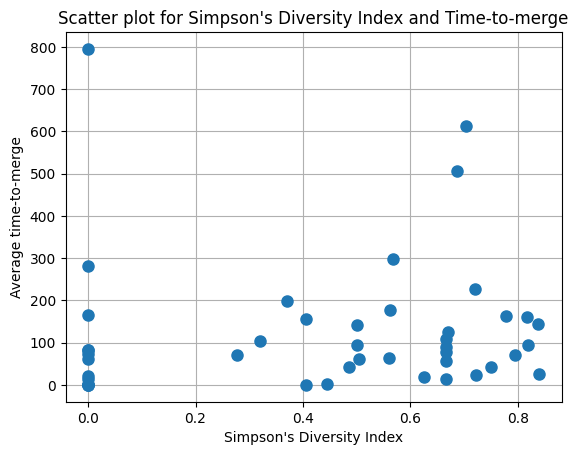

Spearman test for time-to-merge and nr distinct timezones is 0.2530562518405196 (p-value = 0.09744655860207155)
Mann-Whitney U statistic: 0.0
p-value: 9.26817830528497e-09


In [30]:
import statistics
def calculate_simpson_index(data):
    total = sum(data.values())
    simpson_index = sum((count / total) ** 2 for count in data.values())
    diversity_index = 1 - simpson_index
    return diversity_index

# Calculate Simpson Diversity Index for timezone frequencies
simpson_indices=[] # SID for each repo
time_to_merge=[]
for item in data:
    timezone_frequencies={}
    for timezone, count in item.items():
        if isinstance(count, int) and timezone != "repo_name" and timezone != "average_pr_time" and timezone != "nr_timezones" and timezone != "timezone_difference":
            if timezone not in timezone_frequencies:
                timezone_frequencies[timezone] = 0
            timezone_frequencies[timezone] += count
    simpson_indices.append(calculate_simpson_index(timezone_frequencies))
    time_to_merge.append(item['average_pr_time'])

# Scatterplot of Simpson Diversity Index vs time-to-merge
fig, ax = plt.subplots()
ax.plot(simpson_indices, time_to_merge, 'o', markersize=8)
ax.set_xlabel('Simpson\'s Diversity Index')
ax.set_ylabel('Average time-to-merge')
ax.grid(True)
plt.title(f'Scatter plot for Simpson\'s Diversity Index and Time-to-merge')
plt.show()

# Spearman test
statistic, p_value = stats.spearmanr(df['average_pr_time'], simpson_indices)
print(f"Spearman test for time-to-merge and nr distinct timezones is {statistic} (p-value = {p_value})")

# Mann-Whitney U-test
median_simpson_indices = statistics.median(simpson_indices) 
group1, group2=[],[]
for i in simpson_indices:
    if i < median_simpson_indices:
        group1.append(i)
    else:
        group2.append(i)

stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat}")
print(f"p-value: {p_value}")


## Pull Request - level analysis
In this section, we perform the same steps as above, but instead of doing it in a repository-level, we perform it in a pull request level. Thus, instead of calculating the number of distinct timezones in a repository and the average time-to-merge in the repository, we are calculating the number of timezones of the people that were involved (author, reviewer, commenter) in a PR and the exact time-to-merge of that PR. <br><br>
**Before running this script, make sure to run pr_level_analysis.ipynb, which collects and preprocesses the data for this purpose**

### 1. Transform locations to respective timezone 
In the script below, we convert all collaborator locations to their respective UTC timezone. The frequency of the respective UTC timezone is maintained.

In [1]:
import pytz
from datetime import datetime, timezone
import json

f = open("data/pr_participation_filtered.json")
location_data = json.load(f)

# Initialize the output dictionary
output_data = []

for item in location_data:
    repo_name = item['repository']
    participants_timezones = {}
    for location, count in item['participants_timezones'].items():
        try:
            tz_obj = pytz.timezone(location)
            utc_offset = tz_obj.utcoffset(datetime.now())
            if utc_offset.total_seconds() == 0:
                tz_offset_str = "UTC+0"
            else:
                tz_offset_str = f"UTC{'+' if utc_offset.total_seconds() > 0 else '-'}{abs(int(utc_offset.total_seconds() / 3600))}"
            participants_timezones[tz_offset_str] = count
        except pytz.exceptions.UnknownTimeZoneError:
            print(f"Unknown timezone: {location}")

    output_data.append({
        "repository": repo_name,
        "participants_timezones": participants_timezones,
        "time_to_merge": item["time_to_merge"]
    })

with open("data_rq1/RQ1_pr_participation_timezones.json", "w") as outfile:
    json.dump(output_data, outfile)

print("Result written in data_rq1/RQ1_pr_participation_timezones.json")


Result written in data_rq1/RQ1_pr_participation_timezones.json


### 2. Statistical analysis for pull requests

1. Average time to merge per number of distinct timezones in a pull request
We retrieve the averages of pull requests that have one single timezone, 2 distinct timezones, 3 distinct timezones and with 4 distinct timezones. Below are the results of these 4 averages:
   - Average time to merge for pull requests with 1 timezone: 163.09 hours
   - Average time to merge for pull requests with 2 timezones: 205.01 hours
   - Average time to merge for pull requests with 3 timezones: 523.34 hours
   - Average time to merge for pull requests with 4 timezones: 18.29 hours
2. We plot the distribution of number of distinct timezones with the time to merge. The result can be shown in the plot.
3. We perform a Shapiro-Wilks test to check for normal distribution of the data. The findings show that our data is not normally distributed.
4. We perform a Mann-Whitney U test. 
   - This test is performed on the time to merge and pull requests with 1, 2 and 3 distinct timezones, as there exists only one pull request with 4 timezones.
   - For every combination of time to merge and pull requests with 1, 2 and 3 distinct timezone, our p-value is lesser than 0.05, therefore we reject the null hypothesis. 
   - The conclusion of this test is that the time-to-merge for pull requests is statistically significantly different between different numbers of timezones.

PR with highest number of timezones {'UTC-5': 1, 'UTC-7': 1, 'UTC-4': 1, 'UTC+1': 1}
Average time to merge for pull requests with 1 timezone: 163.09 hours
Average time to merge for pull requests with 2 timezones: 205.01 hours
Average time to merge for pull requests with 3 timezones: 523.34 hours
Average time to merge for pull requests with 4 timezones: 18.29 hours


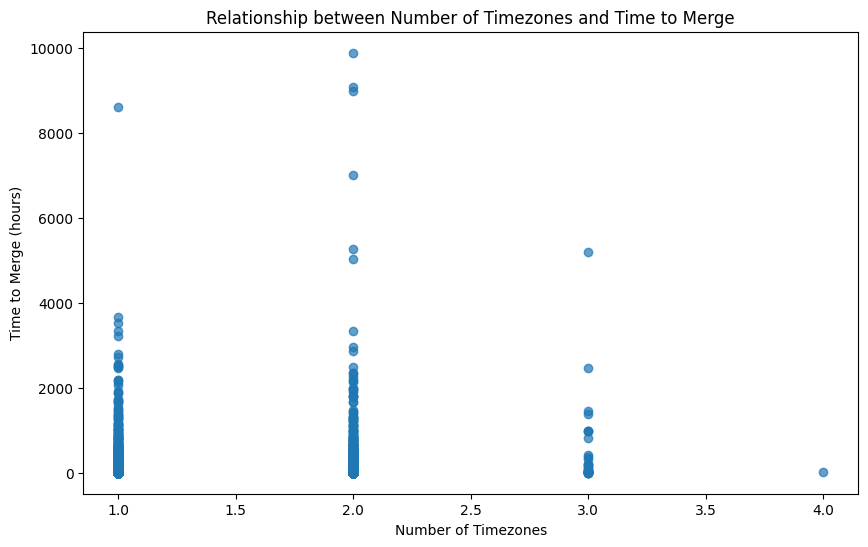

Shapiro-Wilk normality test statistic: 0.3288
Shapiro-Wilk normality test p-value: 0.0000
The time_to_merge data is not likely normally distributed.

Results of Mann-Whitney U-test:
Between 1 and 2 timezones
Mann-Whitney U-test statistic: 943501.5000
Mann-Whitney U-test p-value: 0.0000
The time to merge for pull requests with 1 timezone is significantly different from pull requests with multiple timezones.
Between 1 and 3 timezones
Mann-Whitney U-test statistic: 17618.0000
Mann-Whitney U-test p-value: 0.0020
The time to merge for pull requests with 1 timezone is significantly different from pull requests with multiple timezones.
Between 2 and 3 timezones
Mann-Whitney U-test statistic: 16037.0000
Mann-Whitney U-test p-value: 0.0237
The time to merge for pull requests with 1 timezone is significantly different from pull requests with multiple timezones.


In [2]:
import json
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the data
with open("data_rq1/RQ1_pr_participation_timezones.json", "r") as f:
    data = json.load(f)

# Extract the relevant information
num_timezones = []
time_to_merge = []
for item in data:
    num_timezones.append(len(item["participants_timezones"]))
    if len(item["participants_timezones"]) == 4:
        print("PR with highest number of timezones", item["participants_timezones"])
    time_to_merge.append(item["time_to_merge"])

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(num_timezones, time_to_merge, alpha=0.7)
plt.xlabel("Number of Timezones")
plt.ylabel("Time to Merge (hours)")
plt.title("Relationship between Number of Timezones and Time to Merge")

# Calculate the mean time to merge for each group
one_timezone_count = num_timezones.count(1)
one_timezone_mean = sum([t for n, t in zip(num_timezones, time_to_merge) if n == 1]) / one_timezone_count if one_timezone_count > 0 else 0

two_timezone_count = num_timezones.count(2)
two_timezone_mean = sum([t for n, t in zip(num_timezones, time_to_merge) if n == 2]) / two_timezone_count if two_timezone_count > 0 else 0

three_timezone_count = num_timezones.count(3)
three_timezone_mean = sum([t for n, t in zip(num_timezones, time_to_merge) if n == 3]) / three_timezone_count if three_timezone_count > 0 else 0

four_timezone_count = num_timezones.count(4)
four_timezone_mean = sum([t for n, t in zip(num_timezones, time_to_merge) if n == 4]) / four_timezone_count if four_timezone_count > 0 else 0

print(f"Average time to merge for pull requests with 1 timezone: {one_timezone_mean:.2f} hours")
print(f"Average time to merge for pull requests with 2 timezones: {two_timezone_mean:.2f} hours")
print(f"Average time to merge for pull requests with 3 timezones: {three_timezone_mean:.2f} hours")
print(f"Average time to merge for pull requests with 4 timezones: {four_timezone_mean:.2f} hours")

plt.show()

# Check if the time_to_merge data is normally distributed using Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(time_to_merge)
print(f"Shapiro-Wilk normality test statistic: {shapiro_stat:.4f}")
print(f"Shapiro-Wilk normality test p-value: {shapiro_p:.4f}")

if shapiro_p > 0.05:
    print("The time_to_merge data is likely normally distributed.")
else:
    print("The time_to_merge data is not likely normally distributed.")

# Perform Mann-Whitney U-test
print('\nResults of Mann-Whitney U-test:')
for i in range (1, 4):
    for j in range (i+1, 4):
        i_tz_data=[t for n, t in zip(num_timezones, time_to_merge) if n == i]
        j_tz_data=[t for n, t in zip(num_timezones, time_to_merge) if n == j]

        u_statistic, p_value = stats.mannwhitneyu(i_tz_data, j_tz_data)

        print(f'Between {i} and {j} timezones')
        print(f"Mann-Whitney U-test statistic: {u_statistic:.4f}")
        print(f"Mann-Whitney U-test p-value: {p_value:.4f}")

        if p_value < 0.05:
            print("The time to merge for pull requests with 1 timezone is significantly different from pull requests with multiple timezones.")
        else:
            print("The time to merge for pull requests with 1 timezone is not significantly different from pull requests with multiple timezones.")


